# Web Crawing
 : 웹페이지 데이터 수집

## 크롤링 방법

##### 크롤링 정책
    - robots.txt 파일에 크롤링 정책 설명 : https://www.해당 주소.com/robots.txt
    - 크롤링에 대한 법적 제제 없음
    - 과도한 크롤링으로 서비스에 영향을 주는 경우 문제가 될 수 있음
        - 영업방해, 지적재산권 침해 등 다른 법률에 의해 제재
            ex) 사람인/잡코리아(2008 ~ 2018)
    - 크롤링을 할때는 되도록 api를 사용

- requests package
    - json 문자열 파싱 (동적 크롤링에 주로 사용)
    - html 문자열 파싱 (정적 크롤링에 주로 사용)

In [ ]:
import requests, json
import pandas as pd

##### 1. 실습 ( 웹서비스 분석 : 크롬 개발자 도구 url )
 - 코스피 url : https://m.stock.naver.com/api/index/KOSPI/price?pageSize=10&page=3

In [ ]:
url = 'https://m.stock.naver.com/api/index/KOSPI/price?pageSize=10&page=3'
response = requests.get(url)

print(response) # <Response [200]> : response status

In [ ]:
# request -> string (response)
print(type(response.text)) # string
print()
print(response.text)
print()
print(response.text[:200])

In [ ]:
# response -> list (data)
data = response.json()
print(type(data)) # list
print()
print(data)

In [ ]:
# data -> DataFrame (df)
df = pd.DataFrame(data)[['localTradedAt', 'closePrice']]
print(df.dtypes)
print()
print(df)

In [ ]:
# 함수 생성
def stock_crawling(pagesize, page, code='KOSPI'):
    """stock page crawling

    Args:
        pagesize (int): page size
        page (int): page number
        code (str, optional): KOSPI / KOSDAQ. Defaults to 'KOSPI'.

    Returns:
        DataFrame : 'localTradedAt', 'closePrice'
    """
    
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={pagesize}&page={page}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data)[['localTradedAt', 'closePrice']]
    
    return df


 - 코스닥 url : https://m.stock.naver.com/api/index/KOSDAQ/price?pageSize=10&page=2

In [ ]:
url = 'https://m.stock.naver.com/api/index/KOSDAQ/price?pageSize=10&page=2'
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)[["localTradedAt", "closePrice"]]

print(df)

print(stock_crawling(10,2,'KOSDAQ'))

 - 환율 ( 달러 ) url : https://api.stock.naver.com/marketindex/exchange/FX_USDKRW/prices?page=3&pageSize=10

In [ ]:
url = 'https://api.stock.naver.com/marketindex/exchange/FX_USDKRW/prices?page=3&pageSize=10'
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)[["localTradedAt", "closePrice"]]

print(df)

def exchange_crawling(pagesize, page, code='FX_USDKRW'):
    """money exchange

    Args:
        pagesize (int): page size
        page (int): page number
        code (str, optional): FX_USDKRW, FX_EURKRW, FX_JPYKRW, FX_CNYKRW, each. Defaults to 'FX_USDKRW'.

    Returns:
        _DataFrame : 'localTradedAt', 'closePrice'
    """
    
    url = f'https://api.stock.naver.com/marketindex/exchange/{code}/prices?page={page}&pageSize={pagesize}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data)[['localTradedAt', 'closePrice']]
    
    return df

print(exchange_crawling(10,1))

### 데이터 분석 : 상관관계
 - 피어슨 상관계수
    - 1과 가까울수록 강한 양의 상관관계를 갖는다.
    - -1과 가까울수록 강한 음의 상관계를 갖는다.
    - 0과 가까울수록 관계가 없다.
    - pandas 함수 df.corr()

ex) 달러 환율과 주가 지수의 관계

In [ ]:
kospi = stock_crawling(60, 1)
kosdaq = stock_crawling(60, 1, 'KOSDAQ')
usd = exchange_crawling(60,1)

df = kospi.copy()
df['kosdaq'] = kosdaq["closePrice"]
df['usd'] = usd["closePrice"]
df.rename(columns={'closePrice': 'kospi'},
          inplace=True)

print(df.dtypes)
print()
# 데이터타입 변경 str -> int
df['kospi'] = df['kospi'].apply(lambda data:float(data.replace(',','')))
df['kosdaq'] = df['kosdaq'].apply(lambda data:float(data.replace(',','')))
df['usd'] = df['usd'].apply(lambda data:float(data.replace(',','')))
print(df.dtypes)
print()

print(df[['kospi', 'kosdaq', 'usd']].corr())



In [ ]:
# apply(func)
df = pd.DataFrame([{"age": 23}, {"age": 36}, {"age": 27}])

# 연령대 컬럼을 추가 
def change_ages(age): 
    return age // 10 * 10

df["ages"] = df["age"].apply(change_ages)
print(df)
print()

In [ ]:
### lambda : 일회성 함수
###     - 사용 이유 : 메모리 절약, 간단한 함수 (파라미터를 받아서 바로 리턴)

# 함수 3개 사용 ( 메모리 3개 사용 )
def plus(n1,n2):
    return n1+n2

def minus(n1,n2):
    return n1-n2

def calc(func, n1, n2):
    return func(n1, n2)

print('def : plus, minus, calc')
print(calc(plus, 1,2))
print(calc(minus, 1,2))
print()

# lambda parmeter : return
print('lambda : calc')
print(calc(lambda n1, n2: n1+n2, 1, 2))
print(calc(lambda n1, n2: n1-n2, 1, 2))


### API 데이터 수집
 - application programing interface
 - api를 사용해서 데이터를 수집하는 것은 서비스에 데이터를 제공하는 공식적인 방법으로 데이터 수집

ex) naver api( 파파고 )

In [ ]:
import pandas as pd
import requests, json

# 1. app 등록 > app_key(request_token)
# https://developers.naver.com
CLIENT_ID, CLIENT_SECRET = "Y7kkW5s3waqiGemisIDm", "O0iVtJhKyp"

# 2. Naver API document 확인 > URL
# https://openapi.naver.com/v1/papago/n2mt
url = 'https://openapi.naver.com/v1/papago/n2mt'
txt = '안녕하세요. 반갑습니다. 감사합니다.'
params = {
    'source': 'ko',
    'target': 'en',
    'text':txt
}
headers = {
    "Content-Type": "application/json",
    "X-Naver-Client-Id": CLIENT_ID,
    "X-Naver-Client-Secret": CLIENT_SECRET
}
# 3. request(url, app_key) > json(str)
ppg_response = requests.post(url, json.dumps(params), headers=headers)
print(ppg_response)
print()

# 4. json > list, dict > dataframe
txt_en = ppg_response.json()["message"]["result"]["translatedText"]
print(txt_en)

In [ ]:
# 파파고 함수
def ppg_translate(id,pw,txt,fromNa='ko', toNa='en'):
    """naver papago translate api

    Args:
        id (str): naver api id
        pw (str): naver api secret_
        txt (str): befor translate text
        fromNa (str, optional): . Defaults to 'ko'.
        toNa (str, optional): . Defaults to 'en'.

    Returns:
        _type_: DataFrame, after translate text
    """
    
    params = {
        'source': fromNa,
        'target': toNa,
        'text':txt
    }
    
    headers = {
        "Content-Type": "application/json",
        "X-Naver-Client-Id": id,
        "X-Naver-Client-Secret": pw
    }
    response = requests.post('https://openapi.naver.com/v1/papago/n2mt', json.dumps(params), headers=headers)
    
    return response.json()["message"]["result"]["translatedText"]

print(ppg_translate(CLIENT_ID, CLIENT_SECRET, '크롤링 공부'))

In [ ]:
### covid 번역
CLIENT_ID, CLIENT_SECRET = "Y7kkW5s3waqiGemisIDm", "O0iVtJhKyp"

def ppg_translate_txt(txt):
    """naver papago translate api

    Args:
        txt (str): befor translate text

    Returns:
        _type_: DataFrame, after translate text
    """
    
    params = {
        'source': 'ko',
        'target': 'en',
        'text':txt
    }
    headers = {
        "Content-Type": "application/json",
        "X-Naver-Client-Id": CLIENT_ID,
        "X-Naver-Client-Secret": CLIENT_SECRET
    }
    
    response = requests.post('https://openapi.naver.com/v1/papago/n2mt', json.dumps(params), headers=headers)
    
    return response.json()["message"]["result"]["translatedText"]

covid = pd.read_excel("../excel/covid.xlsx")[["category", "title"]]
covid['en'] = covid['title'].apply(ppg_translate_txt)
print(covid)
# 엑셀 파일 만들기
# covid.to_excel('../excel/covid_en.xlsx', index=False, encoding='utf-8-sig')

ex) naver dataLab

In [ ]:
# datalab.naver.com
import pandas as pd
import requests, json

id, secret = 'Y7kkW5s3waqiGemisIDm', 'O0iVtJhKyp'
url = 'https://openapi.naver.com/v1/datalab/search'
headers = {
    'X-Naver-Client-Id': id,
    'X-Naver-Client-Secret':secret,
    'Content-Type': 'application/json'
}

data = {
    "startDate": "2018-01-01",
    "endDate": "2022-08-04",
    "timeUnit": "month",
    "keywordGroups": [
                    {
                        "groupName": "트위터",
                        "keywords": ["트위터", "트윗",'twitter']
                    },
                    {
                        "groupName": "페이스북",
                        "keywords": ["페이스북","페북", 'facebook']
                    },
                    {
                        "groupName": "인스타그램",
                        "keywords": ["인스타그램","인스타", 'insta', 'instagram']
                    }
                    ]
}
dtLab = requests.post(url=url, data=json.dumps(data) ,headers=headers)

print(dtLab)
# print(dtLab.text)


In [ ]:
dt = dtLab.json()["results"]
print([i['ratio'] for i in dt[0]['data']])
print(type(data['keywordGroups'][0]['keywords'][-1]))
print()

df = pd.DataFrame(dt[0]['data'])['period']
# print(period)
for i in range(len(data['keywordGroups'])):
    df_ = pd.DataFrame(dt[i]['data'])['ratio']
    df = pd.concat([df,df_], axis=1)
    
    df.rename(columns={'ratio':data['keywordGroups'][i]['keywords'][-1]}
              , inplace=True)
    

print(df)

# df = pd.DataFrame({
#     "date": [period["period"] for period in dt[0]["data"]],
#     "twitter": [ratio["ratio"] for ratio in dt[0]["data"]],
#     "facebook": [ratio["ratio"] for ratio in dt[1]["data"]],
#     "instagram": [ratio["ratio"] for ratio in dt[2]["data"]],
# })


In [ ]:
# visualizations
df.plot(figsize=(20, 5))

##### 직방 매물정보 수집
1. 지역 검색
2. 위도, 경도 확인
3. 매물 아이디 확인
4. 매물 정보 확인

In [ ]:
# 위도,경도 hash 패키지
import geohash2

# 1. 지역 검색
addr = '주례동'
url = f'https://apis.zigbang.com/v2/search?leaseYn=N&q={addr}&serviceType=원룸'

response = requests.get(url)
data = response.json()['items'][0]
print(response.json())

lat, lng = data['lat'],data['lng']

# print(response.text)
# print()
# print(data)
# print()
# print(lat,lng)

In [ ]:
# 2. 위도, 경도 확인
geohash = geohash2.encode(lat, lng, precision=5)

print(geohash)

In [ ]:
# 3. 매물 아이디 확인
itm_url = f'https://apis.zigbang.com/v2/items?deposit_gteq=0&domain=zigbang&geohash={geohash}&needHasNoFiltered=true&rent_gteq=0&sales_type_in=전세|월세&service_type_eq=원룸'

itm_respon = requests.get(itm_url)
print(itm_respon)

items = itm_respon.json()["items"] 
print(len(items), items[:2])
print()

ids = [item['item_id'] for item in items]
print(ids)

In [ ]:
# 4. 매물 정보 확인
room_url = 'https://apis.zigbang.com/v2/items/list'
params = {
    'domain': 'zigbang',
    'item_ids':ids,
    'withCoalition': 'true'
}

room_respon = requests.post(url=room_url, params=params)

room = room_respon.json()['items']
columns = ["item_id", "sales_type", "deposit", "rent", "size_m2", "address1", "manage_cost"]

df = pd.DataFrame(room)[columns]
print(df)

In [219]:
# max row, max column 설정
print(pd.options.display.max_columns, pd.options.display.max_rows)
pd.options.display.max_rows = 200

50 60


In [ ]:
# 직방 함수
import pandas as pd
import geohash2, json, requests


def zigbang(addr):
    """zigbang room search

    Args:
        addr (str): address

    Returns:
        DataFrame: columns - ["item_id", "sales_type", "deposit", "rent", "size_m2", "address1", "manage_cost"]
    """
    
    url1 = f'https://apis.zigbang.com/v2/search?leaseYn=N&q={addr}&serviceType=원룸'
    
    dt1 = requests.get(url1).json()['items'][0]
    lat, lng = dt1['lat'],dt1['lng']
    geohash = geohash2.encode(lat, lng, precision=5)
    
    url2 = f'https://apis.zigbang.com/v2/items?deposit_gteq=0&domain=zigbang&geohash={geohash}&needHasNoFiltered=true&rent_gteq=0&sales_type_in=전세|월세&service_type_eq=원룸'
    
    dt2 = requests.get(url2).json()["items"]
    idx = [item['item_id'] for item in dt2]
    
    url3 = 'https://apis.zigbang.com/v2/items/list'
    
    params = {
        'domain': 'zigbang',
        'item_ids':idx,
        'withCoalition': 'true'
    }
    dt3 = requests.post(url=url3, params=params).json()['items']
    columns = ["item_id", "sales_type", "deposit", "rent", "size_m2", "address1", "manage_cost"]
    df = pd.DataFrame(dt3)[columns]
    
    
    return df

print(zigbang('주례동'))

### html
 - 웹 문서를 작성하는 언어
 - 구성요소
    - Document : 한페이지를 나타내는 코드
    - Element : 하나의 레이아웃, Element가 모여서 Document를 만든다.
    - Tag : Element의 종류 정의, 시작/끝 태그가 모여서 Element를 만든다.
    - Attribute : Tag의 속성. 시작 태그에서 태그의 기능을 정의
        - id : 페이지 내 유일한 값
        - class : 페이지 내 중복 가능한 값
        - attr : 속성값
    - Text : 시작과 끝 태그 사이의 내용
 - Element는 계층적 구조를 갖는다.
 



%%html

<div class='wrapper'>
    <button id='b1' clas='btn' value='1'>html1</button>
    <button id='b2' clas='btn' value='2'>html1</button>
</div>


In [ ]:
# 파이썬 부동 소숫점 오류
a, b = 0.1, 0.2
a+b # 0.3 x

In [ ]:
(a+b) == 0.3

In [ ]:
# 해결 : 반올림 사용
round(a+b,1) == 0.3

In [ ]:
# 해결 : 고정소수점 연산
from decimal import Decimal
float(Decimal(str(a)) + Decimal(str(b))) == 0.3


### 정적페이지 데이터 수집
 - 네이버 연관 검색어 수집
 - bs4 : BeautifulSoup, HTML > CSS selector 를 이용하여 수집

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# 1. 웹 서비스 분석 : url
url = 'https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query=kt&oquery=%EC%A1%B4%EB%B0%94%EB%B0%94%ED%86%A0%EC%8A%A4&tqi=hXWxYsprvmsss79TtHossssstaN-185816'

response = requests.get(url)
print(response)

In [ ]:
doc = BeautifulSoup(response.text, 'html.parser')

elements = doc.select('.lst_related_srch > .item')
elements

In [ ]:
dt = [e.select_one('.tit').text for e in elements]
dt

### Gmarket 베트스 상품 수집

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

url = 'http://corners.gmarket.co.kr/Bestsellers'

response = requests.get(url)
response

<Response [200]>

In [5]:
dt = BeautifulSoup(response.text, 'html.parser')
dt

elements = dt.select('#gBestWrap > div > div:nth-child(5) > div > ul > li')

items = []
for e in elements:
    item = {
        'title': e.select_one('.itemname').text
        , 'o-price': e.select_one('.o-price').text.replace(',','').replace('원','')
        , 's-price': e.select_one('.s-price > strong').text.replace(',','').replace('원','')
        , 'img': 'http:' + e.select_one('img').get('data-original')
    }
    
    items.append(item)
    
df = pd.DataFrame(items)


def typeInt(data):
    if data == '':
        return 0
    else:
        return int(data)
    
    
    
# df['o-price'] = df['o-price'].apply(typeInt(data))
df['s-price'] = df['s-price'].apply(lambda data:int(data))

df.to_csv('../csv/gmarket.csv')


df

,title,o-price,s-price,img
0,3900원 균일가 시즌오프 블라우스/티셔츠/원피스/팬츠 外,13000,3900,http://gdimg.gmarket.co.kr/2266434001/still/30...
1,청정우 양지 300gX3팩,31800,15900,http://gdimg.gmarket.co.kr/1587075039/still/30...
2,[한상궁김치]한상궁김치 국산 겉절이 2kg 출고당일생산,,15900,http://gdimg.gmarket.co.kr/1798110680/still/30...
3,[키스포]12%쿠폰 아동 주니어 여름 클리어런스+가을 프리뷰 모음전,22000,6600,http://gdimg.gmarket.co.kr/336394693/still/300...
4,DCOVERS/디커버스/반팔티/티셔츠/여성/남자/빅사이즈,26300,7900,http://gdimg.gmarket.co.kr/2514963907/still/30...
...,...,...,...,...
195,[게스]누구나 22% 게스 여름 티셔츠/데님 파이널 세일,56000,17000,http://gdimg.gmarket.co.kr/1829738400/still/30...
196,[스파클]스파클생수 2L 30병,,15900,http://gdimg.gmarket.co.kr/2007982106/still/30...
197,[G7]베트남 G7 블랙 2g x 200입 (무료배송+랜덤 사은품),19900,13500,http://gdimg.gmarket.co.kr/1692723853/still/30...
198,[미래생활]순수PURE천연펄프 25m 30롤 x 3팩 휴지,31900,28900,http://gdimg.gmarket.co.kr/1899274105/still/30...


### G마켓 이미지 다운로드

     Unnamed: 0                                  title  o-price  s-price  \
0             0       3900원 균일가 시즌오프 블라우스/티셔츠/원피스/팬츠 外  13000.0     3900   
1             1                         청정우 양지 300gX3팩  31800.0    15900   
2             2         [한상궁김치]한상궁김치 국산 겉절이 2kg 출고당일생산      NaN    15900   
3             3  [키스포]12%쿠폰 아동 주니어 여름 클리어런스+가을 프리뷰 모음전  22000.0     6600   
4             4        DCOVERS/디커버스/반팔티/티셔츠/여성/남자/빅사이즈  26300.0     7900   
..          ...                                    ...      ...      ...   
195         195        [게스]누구나 22% 게스 여름 티셔츠/데님 파이널 세일  56000.0    17000   
196         196                      [스파클]스파클생수 2L 30병      NaN    15900   
197         197  [G7]베트남 G7 블랙 2g x 200입 (무료배송+랜덤 사은품)  19900.0    13500   
198         198       [미래생활]순수PURE천연펄프 25m 30롤 x 3팩 휴지  31900.0    28900   
199         199                 탑모델 여름신상 BEST 특가+10%쿠폰  32900.0     9900   

                                                   img  
0    http://gdimg.gmarket.co.k

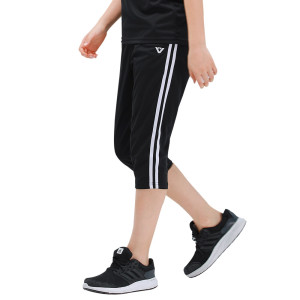

In [7]:
import pandas as pd
import requests, json, os
from PIL import Image as pil


### G마켓 이미지
# csv 파일 불러오기
df = pd.read_csv('../csv/gmarket.csv')
print(df)

# 디렉토리 생성
folder = '../Gmarket_img'
if not os.path.exists(folder):
    os.makedirs(folder)
    

# 이미지 다운로드
# img_link = df.loc[0, 'img']

# response = requests.get(img_link)
# with open(f'{folder}/img01.png', 'wb') as file:
    # file.write(response.content)

# enumerate 하는 경우 컬럼을 불러옴
for idx, data in df[3:5].iterrows():
    filename = "0" * (3 - len(str(idx))) + str(idx) + ".png"
    
    response = requests.get(data["img"])
    
    with open(f'{folder}/{filename}', 'wb') as file:
        file.write(response.content)

pil.open(f"{folder}/003.png")

In [8]:
!ipython profile create

[ProfileCreate] Generating default config file: WindowsPath('C:/Users/User/.ipython/profile_default/ipython_config.py')
[ProfileCreate] Generating default config file: WindowsPath('C:/Users/User/.ipython/profile_default/ipython_kernel_config.py')


In [9]:
!dir C:\Users\User\.ipython\profile_default\startup

 C ����̺��� �������� �̸��� �����ϴ�.
 ���� �Ϸ� ��ȣ: 7C6C-FC35

 C:\Users\User\.ipython\profile_default\startup ���͸�

2022-08-01  ���� 10:03    <DIR>          .
2022-08-01  ���� 10:03    <DIR>          ..
2022-08-01  ���� 10:03               371 README
               1�� ����                 371 ����Ʈ
               2�� ���͸�  109,541,969,920 ����Ʈ ����


### selenium
 : 브라우저의 자동화 목적으로 만들어진 다양한 브라우저와 언어를 지원하는 라이브러리

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By

driver_path = 'C:/Users/User/Desktop/driver/chromedriver.exe'
# chrome 실행

# 브라우저 화면 없는 데이터 수집
options = webdriver.ChromeOptions()
options.add_argument('headless')

driver = webdriver.Chrome(driver_path, options=options)

# 페이지 이동
driver.get("https://daum.net")

# 페이지 사이즈
driver.set_window_size(200,600)

# 페이지 스크롤 조절 : 자바스크립트 코드
driver.execute_script("window.scrollTo(200,300)") 

# alert
# driver.execute_script("alert('hellow selenium!'")

driver.execute_script("window.scrollTo(0,0)") 

# input 문자열 입력
driver.find_element(By.CSS_SELECTOR, '#q').send_keys('pythone')

# 검색 버튼 클릭
driver.find_element(By.CSS_SELECTOR, '#daumSearch > fieldset > div > div > button.ico_pctop.btn_search').click()

# 브라우저 종료
driver.quit()



In [ ]:
def selenium_not_quit(drivePath, url):
    # chrome 실행
    driver = webdriver.Chrome(drivePath)
    # 페이지 이동
    driver.get(url)

    # By.CSS_SELECTOR
    sub_title = driver.find_element(By.CSS_SELECTOR, '#banner-secondary').text
    
    driver.find_element(By.CSS_SELECTOR, "#languages [lang='ko']").click()
    
    # #shoji > div.shoji__door > div > div.main.talks-main
    # #browse-results > div.row.row-sm-4up.row-lg-6up.row-skinny > div
    elements = driver.find_elements(By.CSS_SELECTOR, '#browse-results > div.row.row-sm-4up.row-lg-6up.row-skinny > div')
    
    data = []
    for element in elements:
        data.append({
            "title": element.find_element(By.CSS_SELECTOR, "h4 > .ga-link").text,
            "link": element.find_element(By.CSS_SELECTOR, "h4 > .ga-link").get_attribute("href"),
        })
    df = pd.DataFrame(data)
    df.tail(2)
    
    print(elements)
    
    driver.quit()
    
driver_path = 'C:/Users/User/Desktop/driver/chromedriver.exe'
url = "https://ted.com/talks"

selenium_not_quit(driver_path, url)

### 네이버 중고나라

In [54]:
from selenium import webdriver
from selenium.webdriver.common.by import By


def selenium_not_quit(driver, url):
    driver.get(url)

    # 맥북 검색 : #topLayerQueryInput
    driver.find_element(By.CSS_SELECTOR, '#topLayerQueryInput').send_keys('맥북')
    # 버튼 클릭
    # driver.find_element(By.CSS_SELECTOR, '#cafe-search > form > button').click() : 버튼 element 클릭
    driver.execute_script('searchBoard();') # 자바스크립트 클릭 이벤트
    
    ## iframe 검색
    # 게시물 : ##main-area > div.article-board.result-board.m-tcol-c > table > tbody > tr:nth-child(1)
    # driver.find_elements(By.CSS_SELECTOR, '#main-area > div.article-board.result-board.m-tcol-c > table > tbody > tr') : iframe 이라 검색 안됨
    
    iframe = driver.find_element(By.CSS_SELECTOR, '#cafe_main')
    driver.switch_to.frame(iframe)
    elements = driver.find_elements(By.CSS_SELECTOR, '.article-board > table > tbody > tr') # iframe 스위치 후 검색
    
    # iframe에서 돌아오기
    # driver.switch_to.default_content()
    
    data = []
    for e in elements:
        tmp = {
            'title': e.find_element(By.CSS_SELECTOR, '.article').text
            , 'writer': e.find_element(By.CSS_SELECTOR, '.p-nick').text
        }
        data.append(tmp)
    
    df = pd.DataFrame(data)
    driver.quit()
    
    return df


driver_path = 'C:/Users/User/Desktop/driver/chromedriver.exe'
url = 'https://cafe.naver.com/joonggonara'

driver = webdriver.Chrome(driver_path)
driver.get(url)

print(selenium_not_quit(driver, url))


C:\Users\User\AppData\Local\Temp\ipykernel_21244\2218574169.py:42: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(driver_path)


                                          title             writer
0    2021 맥북프로 레티나 엠원 m1pro m1max 프로 맥스 14인치 판매        topontopcom
1        미개봉/새제품- 맥북 프로 16인치 max cto 모델 판매 합니다.           SSOOOOOZ
2                맥북프로 13인치 20년형 / i7 / 32G / 1T             GM앵그리군
3                        맥북프로 2016 부품용 으로 판매합니다           90735023
4         [매입]고장난 맥북, 노트북, 컴퓨터 선입매입(개인.기업 대량매입)             다사요컴닥터
5   2021년 애플 맥북프로 16형 m1 pro 실버 판매 / 신용확실 (미개봉)          firstpray
6          16인치 2021 맥북프로 레티나 m1MAX M1PRO S급 판매           FRANKCOM
7        [매입] 5분내칼답장 24시간 이온2 플렉스북2 맥북 삼성 lg삽니다  다사요24 01058355451
8        [판/교] 맥북프로 2009년 A1286 mid를 11" 맥북 에어로                서글퍼
9          [판매]맥북프로 2019 16인치 i7/16GB/512GB 풀박스              리퍼노트북
10        [매입]고장난 맥북, 노트북, 컴퓨터 선입매입(개인.기업 대량매입)             다사요컴닥터
11          [풀박] 애플 맥북프로 2019 인텔 16인치 2.3Ghz i9              낯선그림자
12                      맥북프로 A1278 부품용 팝니다 2010               민규만세
13          [매입]방송출연 전국 노트북 맥북 게이밍 아이맥 등 매입 삽니다               

### xpath

In [57]:
import scrapy, requests
from scrapy.http import TextResponse

query = 'kt'
url = f'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=1&ie=utf8&query={query}'

response = requests.get(url)
doc = TextResponse(response.url, body=response.text, encoding='utf-8')

data = doc.xpath('//*[@id="nx_footer_related_keywords"]/div/div[2]/ul/li/a/div/text()').extract()
### //*[@id="nx_footer_related_keywords"]/div/div[2]/ul/li[1]/a
# // : 최상위 엘리먼트
# * : 모든 하위 엘리먼트
# [@id="nx_footer_related_keywords"] : 속성값으로 엘리먼트 선택
# / : 한단계 하위 엘리먼트
# [2] : n 번째 엘리먼트

print(data)

['삼성전자', 'kt 고객센터', 'kt 인터넷', 'ky', '환율', 'kt 대리점', 'kr', '날씨', 'SKT', 'kt 고객센터 전화번호']


### 

In [67]:
class Fibo:
    def __init__(self):
        self.prev = 0
        self.curr = 1
        
    def __iter__(self):
        return self
    
    def __next__(self):
        value = self.curr
        self.curr += self.prev
        self.prev = value
        
        return value
    

1

In [68]:
fibo = Fibo()
type(fibo)

1

In [73]:
next(fibo)

8

In [74]:
# !scrapy startproject gmarket

New Scrapy project 'gmarket', using template directory 'C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\scrapy\templates\project', created in:
    c:\Users\User\Desktop\python\Class\gmarket

You can start your first spider with:
    cd gmarket
    scrapy genspider example example.com


In [75]:
url = 'http://corners.gmarket.co.kr/Bestsellers'

request = requests.get(url)
response = TextResponse(request.url, body=request.text, encoding='utf-8')

In [82]:
# 속성값 @ 사용
links = response.xpath('//*[@id="gBestWrap"]/div/div[3]/div/ul/li/a/@href').extract()
links[:2]

['http://item.gmarket.co.kr/Item?goodscode=2519604129&ver=637953125821156116',
 'http://item.gmarket.co.kr/Item?goodscode=2520466046&ver=637953125821156116']

In [92]:
l = links[0]

request_item = requests.get(l)
response_item = TextResponse(request_item.url, body=request_item.text, encoding='utf-8')

title = response_item.xpath('//*[@id="itemcase_basic"]/div/h1/text()')[0].extract()
price = response_item.xpath('//*[@id="itemcase_basic"]/div/p/span/strong/text()')[0].extract().replace(',','')

title, price

('브라운 면도기 세정액 CCR5+1 ', '25030')